# Figure 3: Ensemble epistasis depends on excited structure stability

## Imports

In [89]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import matplotlib

# Some pretty plot defaults
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False



matplotlib.rcParams['axes.labelsize'] = 25
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

## Functions


+ Temperature, T = 298 K
+ R = 0.001987 (in kcal/K*mol)

In [90]:
def en(G_j,G_k, T=298,R=0.001987):
    """
    Boltzmann-weighted free energy of conformations j and k.
    
    G_j: stability of conformation j
    G_k: stability of conformation k
    T: temperature (K)
    R: gas constant (kcal/K*mol)"""
    
    RT = R*T

    return -RT*np.log(np.exp(-G_j/RT) + np.exp(-G_k/RT))


def get_epistasis(G_i,G_j,G_k,             
                  dG_i_A,dG_j_A,dG_k_A,
                  dG_i_B,dG_j_B,dG_k_B,
                  T=298,R=0.001987):
    """
    Return the epistasis in dG_obs between two mutations introduced into a
    three-conformation system. 
    
    G_i, G_j, G_k: G of conformations i, j, and k for genotype ab
    dG_i_A, dG_j_A, dG_k_A: effect of mutation A on conformations i, j, and k
    dG_i_B, dG_j_B, dG_k_B: effect of mutation B on conformations i, j, and k
    T: temperature (K)
    R: gas constant  (kcal/K*mol)
    
    returns:
        magnitude of epistasis (sign is (AB - aB) - (Ab - ab))
        whether sign in A (True,False)
        whether sign in B (Ture,False)
        type of epistasis as a string (none, magnitude, sign, reciprocal_sign)
    """
    ###################################################################################################
    # observables
    ###################################################################################################
    ab = G_i                   - en(G_j,                   G_k,               T,R)
    Ab = G_i + dG_i_A          - en(G_j + dG_j_A,          G_k + dG_k_A,         T,R)
    aB = G_i +          dG_i_B - en(G_j +          dG_j_B, G_k +          dG_k_B, T,R)
    AB = G_i + dG_i_A + dG_i_B - en(G_j + dG_j_A + dG_j_B, G_k + dG_k_A + dG_k_B, T,R)
 
    ###################################################################################################
    # magnitude
    ###################################################################################################
    mag_in_a = (AB - aB) - (Ab - ab)
    mag_in_b = (AB - Ab) - (aB - ab)
    if mag_in_a == 0:
        return mag_in_a, mag_in_b, False, False, "none"

    ep_type = "magnitude"
    ###################################################################################################
    # sign in A
    ###################################################################################################
    s1 = (AB - aB)/np.abs(AB - aB)
    s2 = (Ab - ab)/np.abs(Ab - ab)
    sign_in_a = False
    
    if s1 != s2:
        ep_type = "sign"
        sign_in_a = True
    ###################################################################################################
    # sign in B
    ###################################################################################################
    s1 = (AB - Ab)/np.abs(AB - Ab)
    s2 = (aB - ab)/np.abs(aB - ab)
    sign_in_b = False
    if s1 != s2:
        ep_type = "sign"
        sign_in_b = True
    ###################################################################################################
    # reciprocal
    ###################################################################################################
    if sign_in_a and sign_in_b:
        ep_type = "reciprocal_sign"
    
    return mag_in_a, mag_in_b, sign_in_a, sign_in_b, ep_type



def plot_surface(some_array,x_array,y_array,flip_color=True,max_value=None,cmap="bwr",
                 xlabel=None,ylabel=None):
    """
    Plot a contour map.
    
    some_array: n x m 2D array
    x_array: array with (at least) [min_x,max_x]
    y_array: array with (at least) [min_y,max_y]
    flip_color: whether or not to flip values in some_array before plotting
    max_value: set min and max color to -max_value and +max_value
        None: get max_value from the array by max(abs(some_array))
        float: use abs(max_value) given
    cmap: matplotlib color map to use
    xlabel: x label
    ylabel: y label
    """
    ###################################################################################################
    # Flip color
    ###################################################################################################
    if flip_color:
        plot_array = -some_array

    else:
        plot_array = some_array
    ###################################################################################################
    # Set max color
    ###################################################################################################
    if max_value is None:
        extreme = np.max(np.abs(plot_array))

    else:
        extreme = np.abs(max_value)
    print(extreme)
    ###################################################################################################
    # Plot it
    ###################################################################################################
    plt.imshow(plot_array,
               cmap=cmap,origin="lower",vmin=-extreme,vmax=extreme,
               extent=[x_array[0],x_array[-1],y_array[0],y_array[-1],],
               interpolation="none")
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
        
        
def _plot_states(G_j,
                 G_k,
                 dG_j=None,
                 dG_k=None,
                 observable=0,
                 x_location=0,arrow_colors=None):
    """
    Draw conformation energies and effects of mutations for a given genotype.
    
    G_j: stability of conformation j before mutation
    G_k: stability of conformation k before mutation
    dG_j: effect of mutations to conformation j.  
           If None, no mutations.
           If float, single mutation (one arrow).
           If list of floats, multiple mutations (each with own arrow)
    dG_k: effect of mutations to conformation k.  (Same syntax as ddG_j).
    observable: observable <dGjk>
    x_location: where to draw states on total plot.
    arrow_colors: color to draw each arrow.
                  If None, all arrows black.
                  Otherwise, must be a list of colors, in order.  Arrows are
                  plotted in order ddG_j, then ddG_k.   
    """
    ###################################################################################################
    # x-placement for edges of genotypes
    ###################################################################################################
    x0 = 0
    x1 = 2
    x2 = 2.5
    x3 = 4.5
    ###################################################################################################
    # If dG_j specified, add dashed line for G_j
    ###################################################################################################
    if dG_j is None:
        dG_j = 0
    else:        
        plt.plot([x0+x_location,x1+x_location],[G_j,G_j],"--",lw=2,color="purple",zorder=10)
    ###################################################################################################
    # If dG_k specified, add dashed line for G_k
    ###################################################################################################
    if dG_k is None:
        dG_k = 0
    else:        
        plt.plot([x2+x_location,x3+x_location],[G_k,G_k],"--",lw=2,color="blue",zorder=10)
    
    
    
    ###################################################################################################
    # If dG_j is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    ###################################################################################################
    try:
        len(dG_j)
        total_dG_j = sum(dG_j)
    except TypeError:
        total_dG_j = dG_j
        dG_j = [dG_j,]

    ###################################################################################################
    # If dG_k is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    ###################################################################################################
    try:
        len(dG_k)
        total_dG_k = sum(dG_k)
    except TypeError:
        total_dG_k = dG_k
        dG_k = [dG_k,]
    
    ###################################################################################################
    # Plot energy levels
    ###################################################################################################
    plt.plot([x0 + x_location, x1 + x_location],[G_j+total_dG_j, G_j+total_dG_j],
             lw=2, color="purple", zorder=10)
    plt.plot([x2 + x_location, x3 + x_location],[G_k+total_dG_k, G_k+total_dG_k], 
             lw=2, color="blue", zorder=10)
    
    ###################################################################################################
    # Plot observable
    ###################################################################################################
    plt.plot([x0 + x_location, x3 + x_location], [observable, observable],
             lw=4, color="black", zorder=0)
    
    
    ###################################################################################################
    # Count through arrow colors
    ###################################################################################################
    color_counter = 0
    
    ###################################################################################################
    ###################################################################################################
    current = G_j
    for counter, j_arrow in enumerate(dG_j):
        
        # If this ddG is 0, do not draw an arrow
        if j_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x0 + (x1 - x0)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = j_arrow/np.abs(j_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,current,0,j_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + j_arrow
        color_counter += 1
        
    ###################################################################################################
    ###################################################################################################
    current = G_k
    for counter, k_arrow in enumerate(dG_k):
        
        # If this ddG is 0, do not draw an arrow
        if k_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x2 + (x3 - x2)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = k_arrow/np.abs(k_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        ###################################################################################################
        # Draw arrow
        ###################################################################################################
        plt.arrow(x,current,0,k_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        ###################################################################################################
        # Update counters
        ###################################################################################################
        current = current + k_arrow
        color_counter += 1
        

    

def plot_state_cycle(G_j=0,G_k=0,
                     dG_Aj=-4,dG_Ak=4,
                     dG_Bj=-4,dG_Bk=4, G_i = 0,
                     T=298,R=0.001987,
                     ylim=(-14,14)):
    """
    dG_j: stability of conformation j, ab genotype
    dG_k: stability of conformation k, ab genotype
    ddG_Aj: effect of mutation A on conformation j
    ddG_Ak: effect of mutation A on conformation k
    ddG_Bj: effect of mutation B on conformation j
    ddG_Bk: effect of mutation B on conformation k
    T: temperature (K)
    R: gas constant  (kcal/K*mol)
    y_lim: y-limits of plot
    """
    ###################################################################################################
    # Calculate observables for ab, Ab, aB, and AB genotypes
    RT = R*T

    ab = en(G_j                 ,  G_k,                  T,R)
    Ab = en(G_j + dG_Aj         ,  G_k + dG_Ak,          T,R)
    aB = en(G_j          + dG_Bj,  G_k          + dG_Bk, T,R)
    AB = en(G_j + dG_Aj + dG_Bj ,  G_k + dG_Ak  + dG_Bk, T,R)
    ###################################################################################################
    ###################################################################################################
    # print relative populations
    ###################################################################################################
    print('pop-ab, j: ' , np.exp(-G_j)/(np.exp(-G_j) + np.exp(-G_k)))
    print('pop-ab, k: ' , np.exp(-G_k)/(np.exp(-G_j) + np.exp(-G_k)), '\n')
    
    print('pop-Ab, j: ' , np.exp(-(G_j + dG_Aj))/(np.exp(-(G_j + dG_Aj)) + np.exp(-(G_k + dG_Ak))))
    print('pop-Ab, k: ' , np.exp(-(G_k + dG_Ak))/(np.exp(-(G_j + dG_Aj)) + np.exp(-(G_k + dG_Ak))), '\n')
    
    print('pop-aB, j: ' , np.exp(-(G_j + dG_Bj))/(np.exp(-(G_j + dG_Bj)) + np.exp(-(G_k + dG_Bk))))
    print('pop-aB, k: ' , np.exp(-(G_k + dG_Bk))/(np.exp(-(G_j + dG_Bj)) + np.exp(-(G_k + dG_Bk))), '\n')

    print('pop-AB, j: ' , np.exp(-(G_j + dG_Aj + dG_Bj))/(np.exp(-(G_j + dG_Aj + dG_Bj)) + np.exp(-(G_k + dG_Ak +  dG_Bk))))
    print('pop-AB, k: ' , np.exp(-(G_k + dG_Ak + dG_Bk))/(np.exp(-(G_j + dG_Aj + dG_Bj)) + np.exp(-(G_k + dG_Ak +  dG_Bk))), '\n')

    
    ###################################################################################################
    # Plot states for each genotype, offseting by x_location for each one
    ###################################################################################################
    _plot_states(G_j, G_k,                                     observable = ab, x_location=0)
    ###################################################################################################
    _plot_states(G_j, G_k, [dG_Aj],            [dG_Ak],        observable = Ab, x_location=6,
                 arrow_colors=["orange","orange"])
    ###################################################################################################
    _plot_states(G_j, G_k,       [dG_Bj],[dG_Bk],              observable = aB, x_location=12,
                 arrow_colors=["green","green"])
    ###################################################################################################
    _plot_states(G_j, G_k, [dG_Aj,dG_Bj],[dG_Bk,dG_Ak],        observable = AB, x_location=18,
                 arrow_colors=["green","orange","green","orange"])
    
    plt.ylim(*ylim)
    plt.ylabel('$G$ (kcal/mol)')
    ###################################################################################################
    # Print epistasis
    ###################################################################################################
    print("Epistasis:",(AB-aB)-(Ab-ab))
    
    

# Panel 3A: Epistasis mapped to thermodynamic parameter space 

Here we are investigating how the starting stabilities of j and k and mutational effects on j and k changes the amount of epistasis we observe in our observable, $<G_{j,k}>$


1.6089768476318467


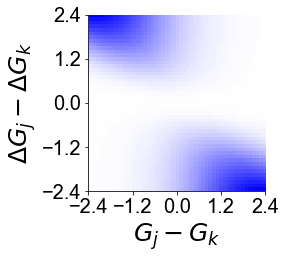

In [91]:
R = 0.001987 # in kcal/K*mol
T = 298.0 # K

G_i = 0
dG_i_A = 0
dG_i_B = 0

G_j = 0
dG_j_A = 0
dG_j_B = 0

G_k = 0
dG_k_A = 0
dG_k_B = 0

d_step_size = 0.1
d_min_value = -2.39006
d_max_value = 2.39006
d_values = np.arange(d_min_value,
                     d_max_value+d_step_size,
                     d_step_size)

split_step_size = 0.1
split_min_value = -2.39006
split_max_value = 2.39006
split_values = np.arange(split_min_value,
                         split_max_value+split_step_size,
                         split_step_size)

output = np.zeros((len(split_values),len(d_values)),dtype=np.float)
for x in range(len(d_values)):
    
    # set mutation_A perturb
    G_j_this = G_j - d_values[x]/2
    G_k_this = G_k + d_values[x]/2
        
    for y in range(len(split_values)):
        
        # set mutation_B perturb
        dG_j_A_this = dG_j_A - split_values[y]/2
        dG_k_A_this = dG_k_A + split_values[y]/2
        dG_j_B_this = dG_j_B - split_values[y]/2
        dG_k_B_this = dG_k_B + split_values[y]/2
                
        mag_in_a, mag_in_b, sign_in_a, sign_in_b, ep_type = get_epistasis(G_i,   G_j_this,   G_k_this,             
                                                                          dG_i_A, dG_j_A_this, dG_k_A_this,
                                                                          dG_i_B, dG_j_B_this, dG_k_B_this,
                                                                          T,R)      
        output[y,x] = mag_in_a
     
    
plot_surface(output,d_values,split_values)
plt.xlabel("$ G_{j} - G_{k}$")
plt.ylabel("$ \Delta G_{j} - \Delta G_{k}$")
plt.xlim(-2.4,2.4)
plt.ylim(-2.4,2.4)
plt.xticks(np.arange(-2.4, 2.5, 1.2))
plt.yticks(np.arange(-2.4, 2.5, 1.2))
plt.tight_layout()
#plt.savefig("fig3a-surface.pdf")
plt.show()

# Panel 3B: Scenario B


+ Example of no epistasis because only a single excited structure is appreciably populated.

pop-ab, j:  0.8712488184243782
pop-ab, k:  0.12875118157562188 

pop-Ab, j:  0.9786284568164161
pop-Ab, k:  0.021371543183583894 

pop-aB, j:  0.9786284568164161
pop-aB, k:  0.021371543183583894 

pop-AB, j:  0.9967831725845453
pop-AB, k:  0.0032168274154547104 

Epistasis: -0.021173273082999433


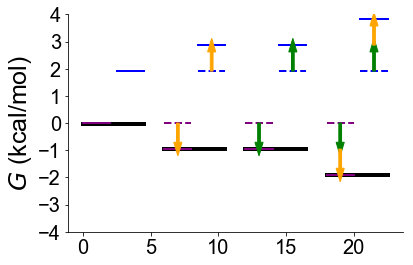

In [92]:
plot_state_cycle(0, # G_j
                 8/4.184, # G_k
                 -4/4.184, # dG_Aj
                 4/4.184, # dG_Ak
                 -4/4.184, # dG_Bj
                 4/4.184) #dG_Bk
plt.ylim(-4,4)
plt.yticks(np.arange(-4,4.5,1))
#plt.savefig("fig3B_scenario-B.pdf")
plt.show()

# Panel 3C: Scenario C


+ Example of epistasis because both states are populated (equal starting stabilities)

pop-ab, j:  0.5
pop-ab, k:  0.5 

pop-Ab, j:  0.8712488184243782
pop-Ab, k:  0.12875118157562185 

pop-aB, j:  0.8712488184243782
pop-aB, k:  0.12875118157562185 

pop-AB, j:  0.9786284568164161
pop-AB, k:  0.021371543183583894 

Epistasis: -0.3653750320806075


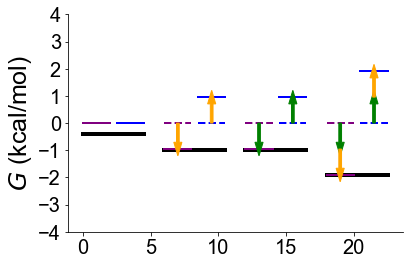

In [93]:
plot_state_cycle(0, # starting stability G_j 
                 0, # starting stability G_k 
                 -4/4.184, #dGA_j
                 4/4.184,  #dGA_k
                 -4/4.184, #dGB_j
                 4/4.184)  #dGB_k
plt.ylim(-4,4)
plt.yticks(np.arange(-4,4.5,1))
#plt.savefig("fig3C_scenario-C.pdf")
plt.show()

# Panel 3D: Scenario D


+ Example of no epistasis because both mutations have the same effect on j and k

pop-ab, j:  0.5
pop-ab, k:  0.5 

pop-Ab, j:  0.5
pop-Ab, k:  0.5 

pop-aB, j:  0.5
pop-aB, k:  0.5 

pop-AB, j:  0.5
pop-AB, k:  0.5 

Epistasis: -2.220446049250313e-16


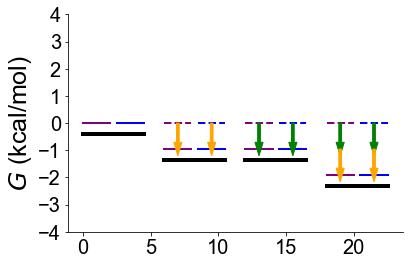

In [94]:
plot_state_cycle(0,        #G_j
                 0,        #G_k
                 -4/4.184, #dG_Aj
                 -4/4.184, #dG_Ak
                 -4/4.184, #dG_Bj
                 -4/4.184) #dG_Bk
plt.ylim(-4,4)
plt.yticks(np.arange(-4,4.5,1))
#plt.savefig("fig3D_scenario-D.pdf")
plt.show()

In [25]:
BETA = (1/(298*0.001985))

def pops(G_apo, G_ca, G_capep,          
         beta=BETA):
    """
    Calculate the relative fraction of apo, ca, capep
    
    dG_apo: effect of mutations on apo stability
    dG_ca: effect of mutations on ca stability
    dG_capep: effect of mutations on capep stability
    G_apo: free energy of apo state
    G_ca: free energy of ca state (no ca)
    G_capep: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT (kcal/mol @ 298K)  
    
    Returns the fractional populations of apo, ca, and capep
    """
    w_apo =    np.exp(-(beta)*(G_apo))
    w_ca =     np.exp(-(beta)*(G_ca))
    w_capep =  np.exp(-(beta)*(G_capep))
    
    Z = w_apo + w_ca + w_capep

    return w_apo/Z, w_ca/Z, w_capep/Z

def dg_obs(G_apo, G_ca, G_capep,       # wildtype thermodynamic parameters
           beta=BETA):                           # RT
    """
    Calculate the free energy of the capep state.
    
    dG_apo: effect of mutations on apo stability
    dG_ca: effect of mutations on ca stability
    dG_capep: effect of mutations on capep stability
    G_apo: free energy of apo state
    G_ca: free energy of ca state (no ca)
    G_capep: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT (kcal/mol @ 298K)  
    
    Returns dG(apo + ca -> capep)
    """
    
    w_apo, w_ca, w_capep = pops(G_apo,G_ca,G_capep,
                                beta)
    
    return -(1/beta)*np.log((w_apo + w_ca))

In [26]:
en(0,0)

-0.4104304674362382

In [28]:
dg_obs(-1,0,-1)

0.36207347857176087

In [21]:
en(-1,0)

-1.1003769717458927